In [26]:
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install pennylane
!pip install pytorch
!pip install pytorch-lightning
!pip install qiskit
!pip install qiskit-algorithms
!pip install pandas
!pip install jupyter
!pip install ipykernel

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\hp\AppData\Local\Temp\pip-install-2kudcfvj\pytorch_d46baf4994bb4e36b17f9fafd3b200e1\setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as tf
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [28]:
dfi = pd.read_csv('https://raw.githubusercontent.com/SPUTnik-42/Q-LSTM/main/LSTM_QLSTM_WEN_LI/data/beijing_aqi.csv')
dfi

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [29]:
dfi = dfi.loc[dfi['year'] > 2013]
dfi = dfi.drop(['No','year','month','day','hour'], axis=1)
dfi

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
35064,24.0,-20,7.0,1014.0,NW,143.48,0,0
35065,53.0,-20,7.0,1013.0,NW,147.50,0,0
35066,65.0,-20,6.0,1013.0,NW,151.52,0,0
35067,70.0,-20,6.0,1013.0,NW,153.31,0,0
35068,79.0,-18,3.0,1012.0,cv,0.89,0,0
...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [30]:
dfi.isnull().sum()

pm2.5    99
DEWP      0
TEMP      0
PRES      0
cbwd      0
Iws       0
Is        0
Ir        0
dtype: int64

In [31]:
dfi['cbwd_deg'] = dfi['cbwd'].apply(lambda x: 315  if x == 'NW' else ( 45 if x == 'NE' else (135 if x== 'SE' else  225 )))
dfi

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,cbwd_deg
35064,24.0,-20,7.0,1014.0,NW,143.48,0,0,315
35065,53.0,-20,7.0,1013.0,NW,147.50,0,0,315
35066,65.0,-20,6.0,1013.0,NW,151.52,0,0,315
35067,70.0,-20,6.0,1013.0,NW,153.31,0,0,315
35068,79.0,-18,3.0,1012.0,cv,0.89,0,0,225
...,...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,231.97,0,0,315
43820,10.0,-22,-3.0,1034.0,NW,237.78,0,0,315
43821,10.0,-22,-3.0,1034.0,NW,242.70,0,0,315
43822,8.0,-22,-4.0,1034.0,NW,246.72,0,0,315


In [32]:
df = dfi.dropna()
df = df.reset_index()
df = df.drop(['index','cbwd'], axis=1)
df

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_deg
0,24.0,-20,7.0,1014.0,143.48,0,0,315
1,53.0,-20,7.0,1013.0,147.50,0,0,315
2,65.0,-20,6.0,1013.0,151.52,0,0,315
3,70.0,-20,6.0,1013.0,153.31,0,0,315
4,79.0,-18,3.0,1012.0,0.89,0,0,225
...,...,...,...,...,...,...,...,...
8656,8.0,-23,-2.0,1034.0,231.97,0,0,315
8657,10.0,-22,-3.0,1034.0,237.78,0,0,315
8658,10.0,-22,-3.0,1034.0,242.70,0,0,315
8659,8.0,-22,-4.0,1034.0,246.72,0,0,315


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8661 entries, 0 to 8660
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pm2.5     8661 non-null   float64
 1   DEWP      8661 non-null   int64  
 2   TEMP      8661 non-null   float64
 3   PRES      8661 non-null   float64
 4   Iws       8661 non-null   float64
 5   Is        8661 non-null   int64  
 6   Ir        8661 non-null   int64  
 7   cbwd_deg  8661 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 541.4 KB


In [34]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_deg
0,24.0,-20,7.0,1014.0,143.48,0,0,315
1,53.0,-20,7.0,1013.0,147.50,0,0,315
2,65.0,-20,6.0,1013.0,151.52,0,0,315
3,70.0,-20,6.0,1013.0,153.31,0,0,315
4,79.0,-18,3.0,1012.0,0.89,0,0,225
...,...,...,...,...,...,...,...,...
6923,272.0,12,15.0,1015.0,1.78,0,0,45
6924,296.0,11,14.0,1015.0,0.89,0,0,135
6925,315.0,11,13.0,1016.0,1.78,0,0,135
6926,357.0,11,13.0,1016.0,0.89,0,0,225


In [35]:
train.iloc[:,:1]

,pm2.5
0,24.0
1,53.0
2,65.0
3,70.0
4,79.0
...,...
6923,272.0
6924,296.0
6925,315.0
6926,357.0


In [36]:
train.iloc[:,1:]

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_deg
0,-20,7.0,1014.0,143.48,0,0,315
1,-20,7.0,1013.0,147.50,0,0,315
2,-20,6.0,1013.0,151.52,0,0,315
3,-20,6.0,1013.0,153.31,0,0,315
4,-18,3.0,1012.0,0.89,0,0,225
...,...,...,...,...,...,...,...
6923,12,15.0,1015.0,1.78,0,0,45
6924,11,14.0,1015.0,0.89,0,0,135
6925,11,13.0,1016.0,1.78,0,0,135
6926,11,13.0,1016.0,0.89,0,0,225


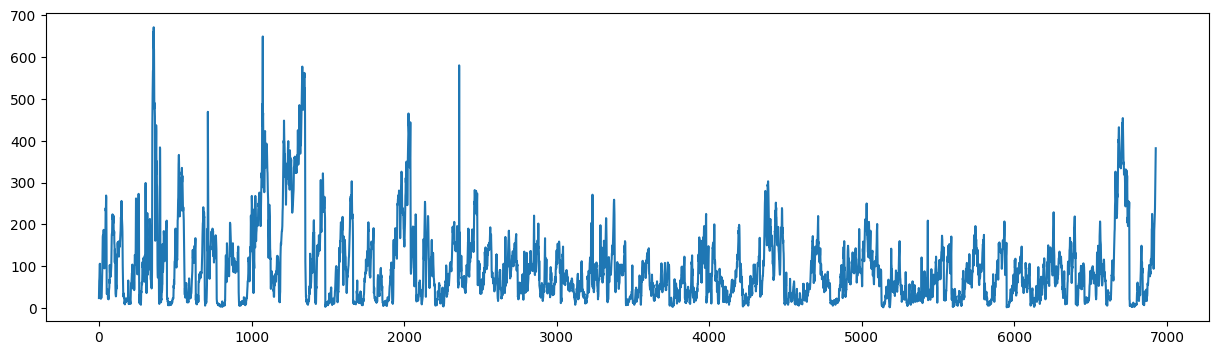

In [37]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["pm2.5"])
plt.show()

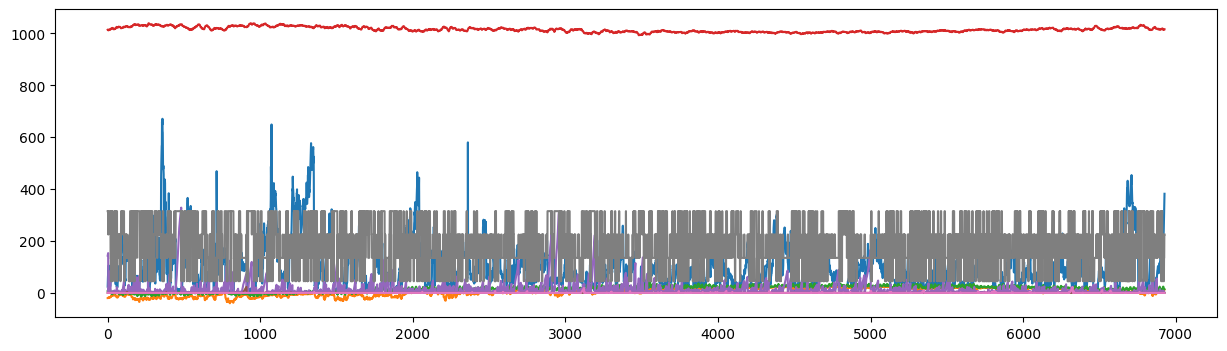

In [38]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [39]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,:1])
    data = scaler2.fit_transform(data.iloc[:,1:])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [40]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [41]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [42]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [232]:
print(X_train.shape)
batch_size, seq_length, features_size =X_train.size()
print(batch_size)
X_train[0][0]

torch.Size([6918, 10, 7])
6918


tensor([-1.7466, -0.8084, -0.0645,  4.4400, -0.0539, -0.1426,  1.4411])

In [283]:
device = "cpu"

In [284]:
def init_hidden(x: torch.Tensor, hidden_size: int, num_dir: int = 1, xavier: bool = True):
    
    if xavier:
        return nn.init.xavier_normal_(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)
    return Variable(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)

In [285]:
class AttnEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=1
        )
        self.attn = nn.Linear(
            in_features=2 * self.hidden_size + self.seq_len,
            out_features=1
        )
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, input_data: torch.Tensor):
        
        h_t, c_t = (init_hidden(input_data, self.hidden_size),
                    init_hidden(input_data, self.hidden_size))

        attentions, input_encoded = (Variable(torch.zeros(input_data.size(0), self.seq_len, self.input_size)),
                                     Variable(torch.zeros(input_data.size(0), self.seq_len, self.hidden_size)))

        
        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1).to(device)), dim=2).to(
                device)  # bs * input_size * (2 * hidden_dim + seq_len)

            e_t = self.attn(x.view(-1, self.hidden_size * 2 + self.seq_len))  # (bs * input_size) * 1
            a_t = self.softmax(e_t.view(-1, self.input_size)).to(device)  # (bs, input_size)

            weighted_input = torch.mul(a_t, input_data[:, t, :].to(device))  # (bs * input_size)
            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(weighted_input.unsqueeze(0), (h_t, c_t))

            input_encoded[:, t, :] = h_t
            attentions[:, t, :] = a_t

        return attentions, input_encoded

In [313]:
class AttnDecoder(nn.Module):
    def __init__(self,  hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnDecoder, self).__init__()
        self.seq_len = seq_len
        self.encoder_hidden_size = hidden_size
        self.decoder_hidden_size = hidden_size
        self.out_feats = 1

        self.attn = nn.Sequential(
            nn.Linear(2 * self.decoder_hidden_size + self.encoder_hidden_size, self.encoder_hidden_size),
            nn.Tanh(),
            nn.Linear(self.encoder_hidden_size, 1)
        )
        self.lstm = nn.LSTM(input_size=self.out_feats, hidden_size=self.decoder_hidden_size)
        self.fc = nn.Linear(self.encoder_hidden_size + self.out_feats, self.out_feats)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size, self.out_feats)
        self.fc.weight.data.normal_()

    def forward(self, input_encoded: torch.Tensor, y_history: torch.Tensor):
        
        h_t, c_t = (
            init_hidden(input_encoded, self.decoder_hidden_size), init_hidden(input_encoded, self.decoder_hidden_size))
        context = Variable(torch.zeros(input_encoded.size(0), self.encoder_hidden_size))

        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           input_encoded.to(device)), dim=2)

            x = tf.softmax(
                self.attn(
                    x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size)
                ).view(-1, self.seq_len),
                dim=1)

            context = torch.bmm(x.unsqueeze(1), input_encoded.to(device))[:, 0, :]  # (batch_size, encoder_hidden_size)
            #print('context yhis',context.to(device).size(), y_history.to(device).size())
            y_tilde = self.fc(torch.cat((context.to(device), y_history.to(device)),
                                        dim=1))  # (batch_size, out_size)

            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(y_tilde.unsqueeze(0), (h_t, c_t))

        return self.fc_out(torch.cat((h_t[0], context.to(device)), dim=1))  # predicting value at t=self.seq_length+1



In [314]:
class AutoEncForecast(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AutoEncForecast, self).__init__()
        self.encoder = AttnEncoder(input_size, hidden_size, batch_first,seq_len).to(device)
        self.decoder = AttnDecoder(hidden_size, batch_first, seq_len).to(device)

    def forward(self, encoder_input: torch.Tensor, y_hist: torch.Tensor, return_attention: bool = False):
       
        attentions, encoder_output = self.encoder(encoder_input)
        outputs = self.decoder(encoder_output, y_hist.float())
        outputs = torch.transpose(outputs, 0, 1)
        if return_attention:
            return outputs, attentions
        return outputs

In [315]:
batch_size = 7
learning_rate = 0.004
num_epochs = 1
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = AutoEncForecast(input_size=7, hidden_size= 21)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [316]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0


for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x,y)
        
        label = torch.transpose(y, 0, 1)    
        #print(output)
        #print(torch.transpose(y, 0, 1))
        
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/1]  LossQ:50.40166572791895 


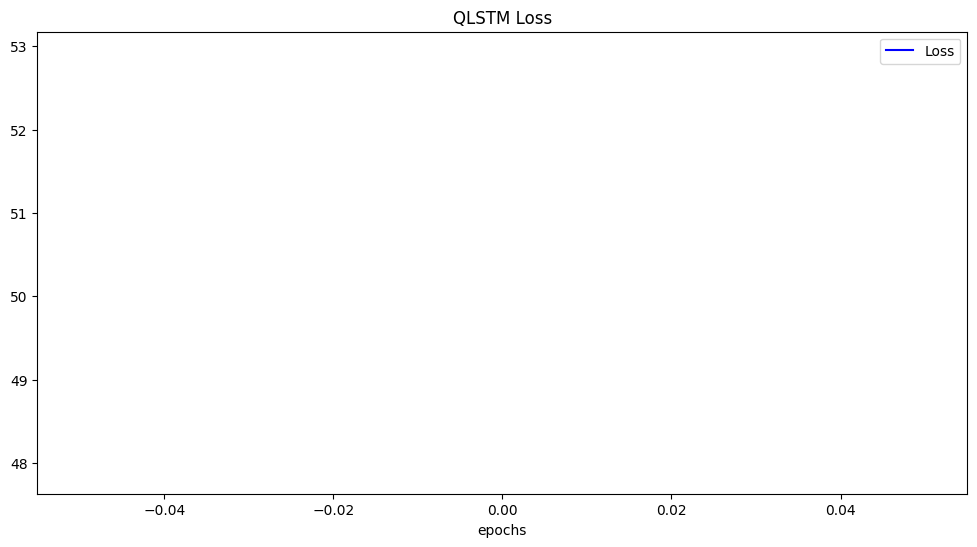

In [328]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [329]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
#print(X_train[0].unsqueeze(0))
#print(y_train[0].unsqueeze(0))

1723
6918
6918


In [330]:
def predict(X,y, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_star = model(X[i].unsqueeze(0),y[i].unsqueeze(0))
            '''if list(y_star.size()) == [1,1]:
                y_star = y_star.tolist()
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star = torch.tensor(y_star)'''
            output = torch.cat((output, y_star), 0)


    return output

In [331]:
pred_y_test = predict(X_test,y_test, modelQ)
print(len(pred_y_test))
print(pred_y_test)

1723
tensor([[ 2.4300],
        [ 2.3962],
        [ 1.8762],
        ...,
        [-0.8461],
        [-0.8800],
        [-0.8625]])


In [332]:
pred_y_train = predict(X_train,y_train, modelQ)
print(len(pred_y_train))
print(pred_y_train)

6918
tensor([[-0.5195],
        [-0.7376],
        [-0.8335],
        ...,
        [ 2.5287],
        [ 2.9748],
        [ 3.2265]])


In [333]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [334]:
print(len(pred_y_train))
print(len(y_train))

6918
6918


In [335]:
pred_y_test

tensor([[ 2.4300],
        [ 2.3962],
        [ 1.8762],
        ...,
        [-0.8461],
        [-0.8800],
        [-0.8625]])

In [336]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:10.176266448129487


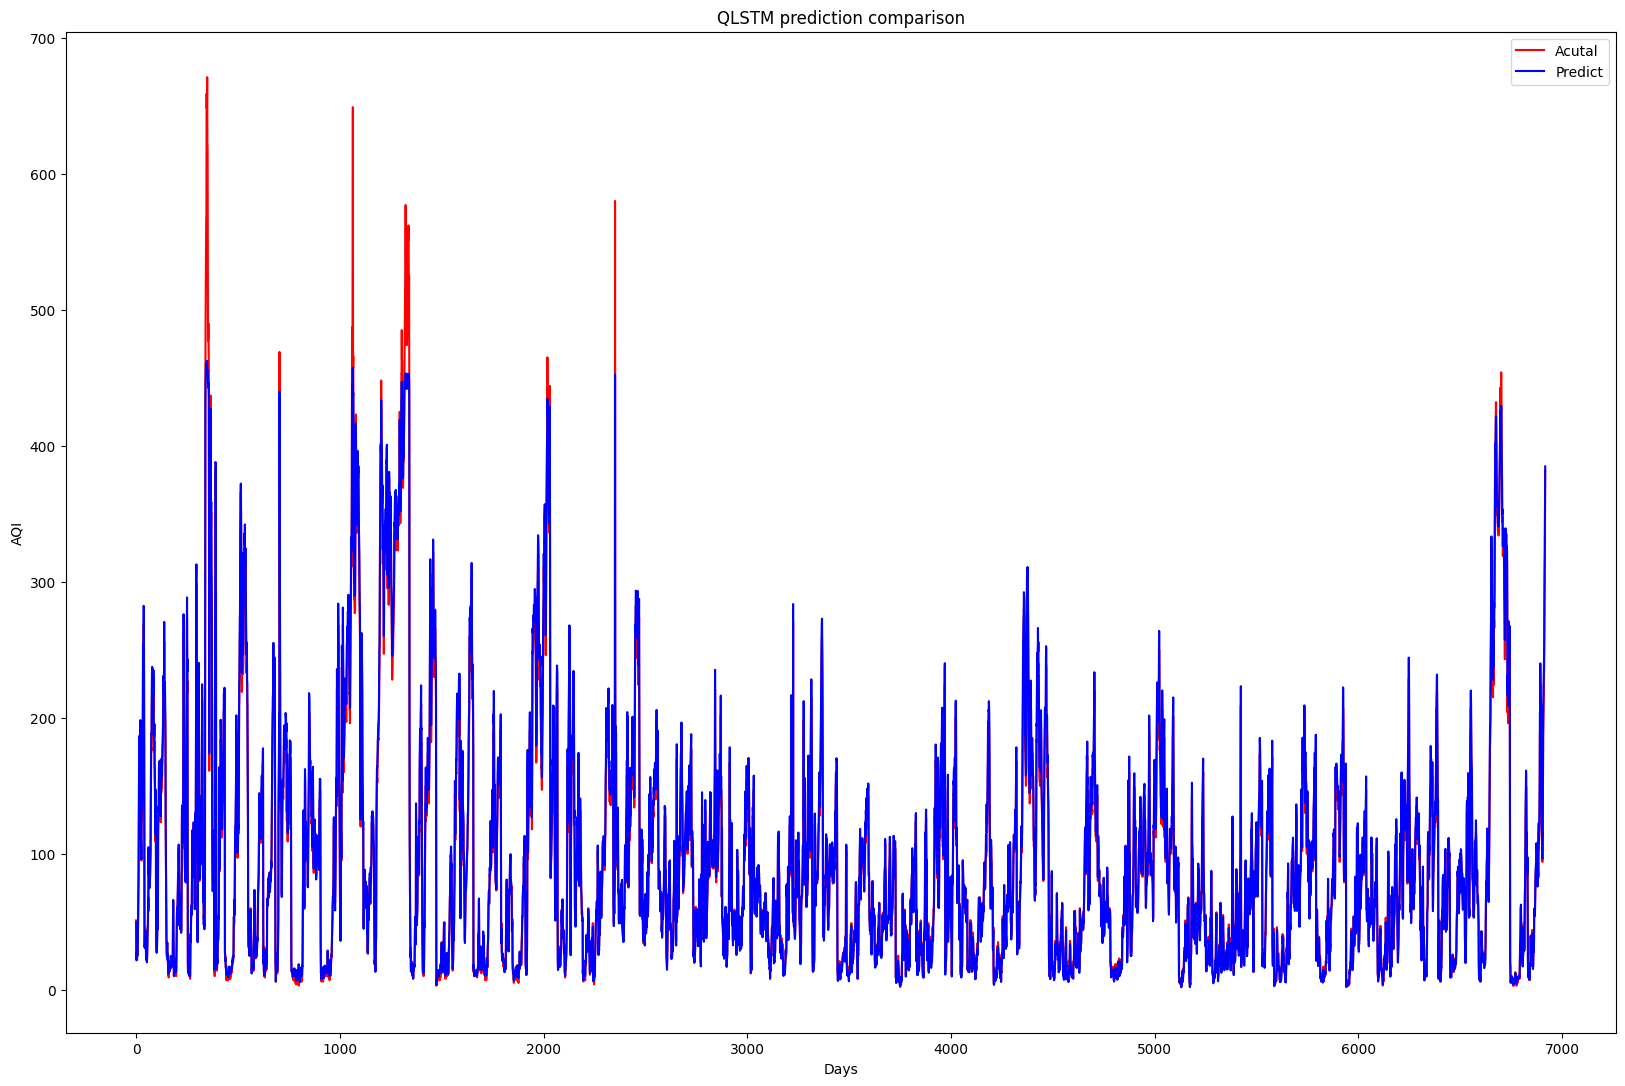

In [337]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:7.659154482674025


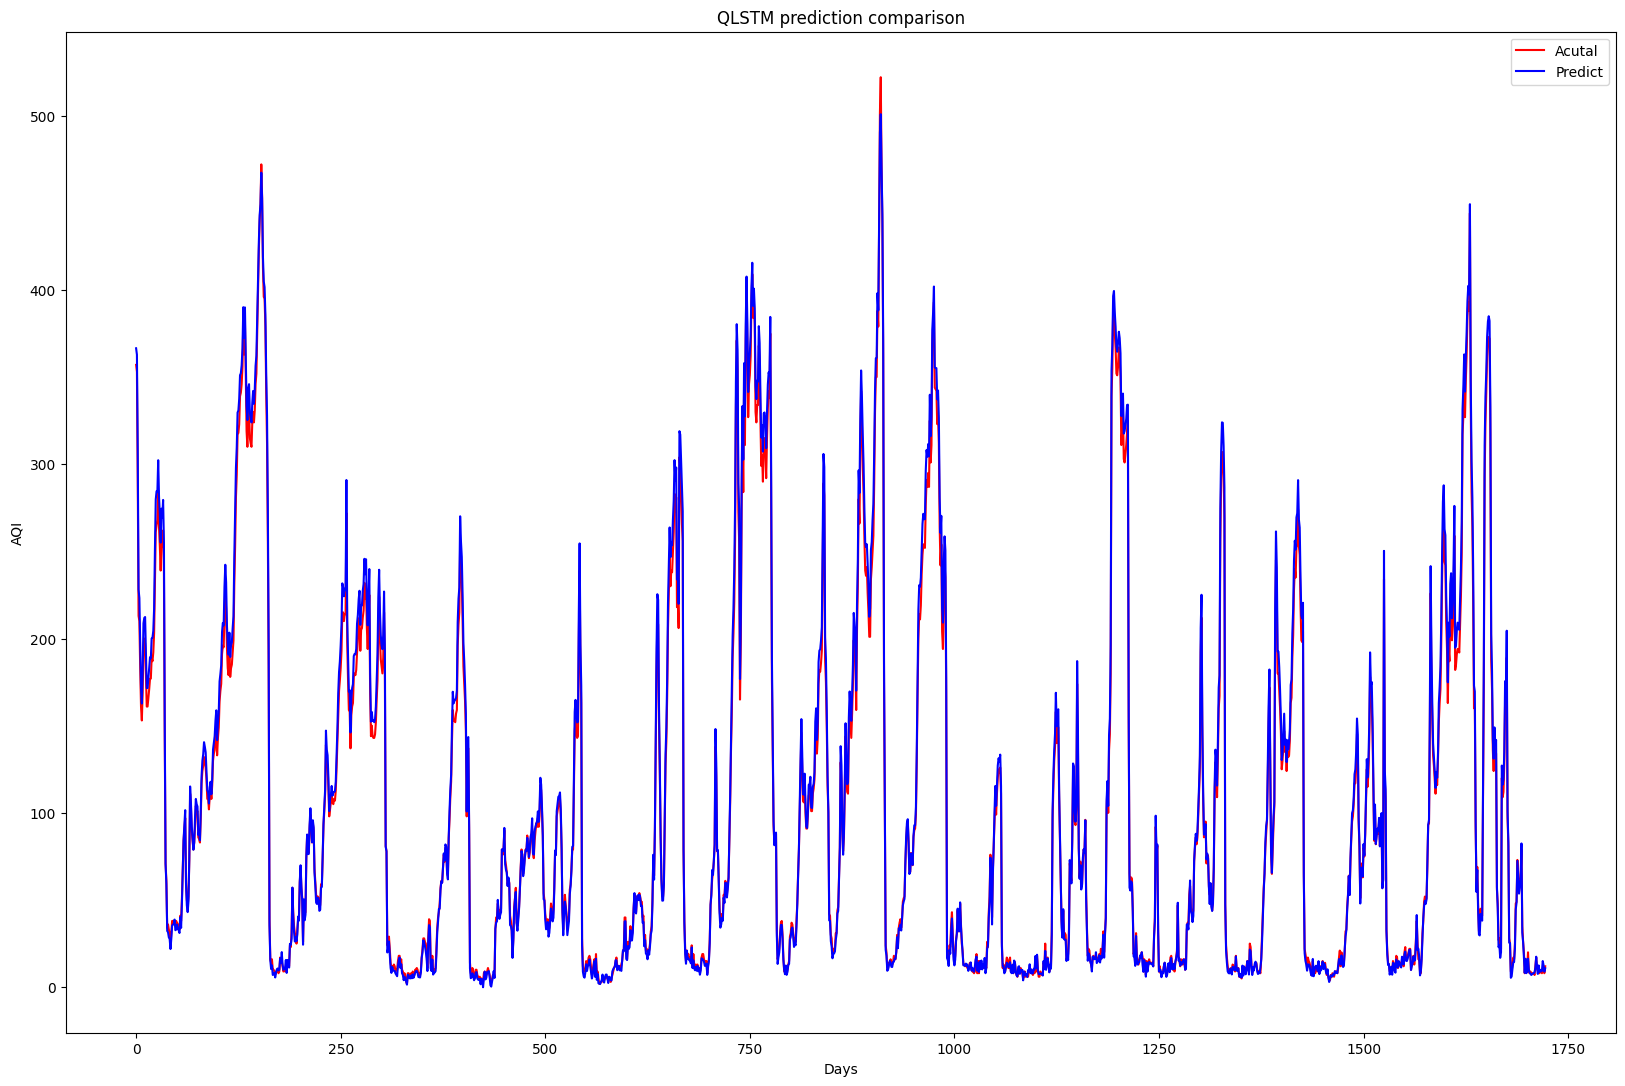

In [338]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c058ba4d-582e-4fe4-bee3-96c92b213f9e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>